### Importing the Required packages

In [4]:
# required packages
import re
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, split, explode, countDistinct, sum, round, lit, lower
import plotly.express as px
import plotly.io as pio
from IPython.display import Image

### Spark Session


In [5]:
# spark session
spark = (
    SparkSession
    .builder
    .appName('Food and Nutrition')
    .master('local[*]')
    .getOrCreate()
)

spark

### Dataset


In [6]:
# Reading the tsv file using spark
food_data = spark.read\
    .format("csv")\
        .options(inferSchema = "True",header = "True", sep = "\t" )\
            .load('data/food_nutrition.tsv')

In [7]:
# Number of Partitions created by Spark
food_data.rdd.getNumPartitions()

16

### Additives Analysis in Food and Nutrition Data

In [8]:
# Additives data with NA rows dropped
additives_data = food_data.select(col('brands'),
                                  col('product_name'),
                                  col('additives_n'), 
                                  col('additives'), 
                                  col('additives_en'),
                                  col('additives_tags'))

additives_data = additives_data.dropna()

In [9]:
# Count of the data with the additives information
additives_data.count()

167561

In [10]:
# Sample Additives data
additives_data.show()

+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+
|              brands|        product_name|additives_n|           additives|        additives_en|      additives_tags|
+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+
|      Daddy's Muesli|      Organic Muesli|          1| [ org-oats -> en...|  E307c - Tocopherol|            en:e307c|
|            Sunridge|Antioxidant Mix -...|          1| [ chocolate-star...|E322 - Lecithins,...|    en:e322,en:e322i|
|            Sunridge|Fire Roasted Hatc...|          2| [ dry-roasted-al...|E330 - Citric aci...|     en:e330,en:e339|
|            Sunridge|Peanut Butter Pow...|          3| [ peanut-butter ...|E170 - Calcium ca...|en:e170,en:e322,e...|
|            Sunridge|Wasabi Tamari Alm...|          1| [ almonds -> en:...|  E330 - Citric acid|             en:e330|
|            Sunridge|Dark Chocolate Co...|     

In [8]:
# Sample brands with the additives data present
additives_data.select(col('brands')).distinct().show(truncate=False)

+-------------------------------------------+
|brands                                     |
+-------------------------------------------+
|Eco-Dent                                   |
|Lotus Brands  Inc.                         |
|Ling Ling                                  |
|Don Roth's Blackhawk                       |
|Flower                                     |
|Jelly Belly                                |
|Dierbergs Kitchen                          |
|Silk                                       |
|Whole Foods Market,  Allegro Coffee Company|
|Joey D's                                   |
|Motto's                                    |
|Foco                                       |
|Trolli                                     |
|Koon Chun Hing Kee Soy & Sauce             |
|Lehi Roller Mills Co. Inc.                 |
|Sweet Baby Ray's                           |
|Bruce's                                    |
|Back To Basics Products  Llc               |
|Big Y                            

In [11]:
# Number of products per brand, filtered by brands having more than 400 products
product_count_by_brands = additives_data.groupBy('brands').\
               agg(countDistinct('product_name').alias('Distinct Products count')).\
               filter(col('Distinct Products count') > 400).\
               orderBy(col('Distinct Products count').desc())
               
product_count_by_brands.show()

+------------------+-----------------------+
|            brands|Distinct Products count|
+------------------+-----------------------+
|         Carrefour|                   1692|
|            Meijer|                   1209|
|            Auchan|                   1194|
|                 U|                   1192|
|            Kroger|                   1118|
|      Leader Price|                    955|
|            Casino|                    852|
|           Spartan|                    849|
|          Roundy's|                    812|
|             Ahold|                    786|
|       Great Value|                    777|
|              Cora|                    666|
|              Weis|                    612|
|          Shoprite|                    529|
|         Food Club|                    529|
|     Fleury Michon|                    487|
|     Harris Teeter|                    487|
|     Target Stores|                    478|
|         Food Lion|                    462|
|Essential

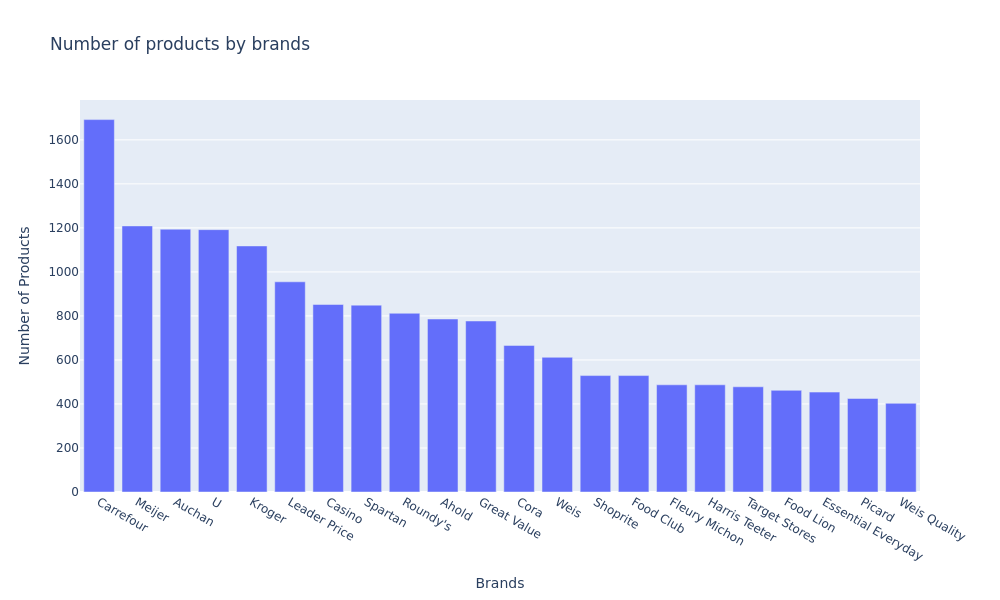

In [12]:
# plotting the above data for clarity
# convert to pandas
product_count_by_brands_df = pd.DataFrame(product_count_by_brands.collect(), \
                                          columns=product_count_by_brands.columns)

# plot
fig = px.bar(product_count_by_brands_df, 
             x='brands', 
             y='Distinct Products count',
             title="Number of products by brands",
             labels={'Distinct Products count': 'Number of Products', 
                     'brands': 'Brands'},
             )

fig.update_layout(width=1000, height=600)

fig.write_image("plots/number_of_products_by_brands.png")
display(Image(filename='plots/number_of_products_by_brands.png'))

In [14]:
# Total additives added by each brands, filtered by number of additives more than 1000 products
brands_additives_data = additives_data.groupBy('brands')\
                                       .agg(sum(col('additives_n')).alias('total_additives'))\
                                       .filter(col('total_additives') > 1000)\
                                       .orderBy(col('total_additives').desc())    
brands_additives_data.show()

+------------------+---------------+
|            brands|total_additives|
+------------------+---------------+
|            Meijer|           5794|
|            Kroger|           5464|
|         Carrefour|           5232|
|            Auchan|           3937|
|           Spartan|           3903|
|       Great Value|           3603|
|                 U|           3520|
|          Roundy's|           3448|
|              Weis|           3288|
|      Leader Price|           3084|
|            Casino|           2777|
|             Ahold|           2775|
|         Food Club|           2489|
|              Cora|           2324|
|     Harris Teeter|           2047|
|         Food Lion|           1975|
|            Haribo|           1876|
|          Shoprite|           1840|
|Essential Everyday|           1827|
|      Weis Quality|           1608|
+------------------+---------------+
only showing top 20 rows



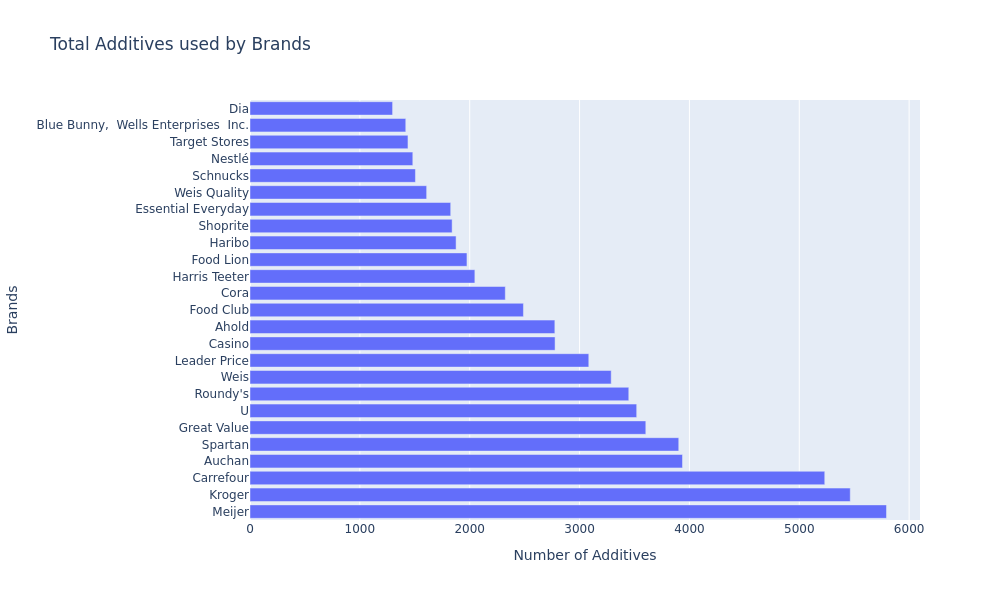

In [15]:
# plotting the above data for clarity
# convert to pandas
brands_addtitives_df = pd.DataFrame(brands_additives_data.collect(), 
                                    columns=brands_additives_data.columns)

# plot
fig = px.bar(brands_addtitives_df[:25], 
             x='total_additives', 
             y='brands',
             title="Total Additives used by Brands",
             labels={'total_additives': 'Number of Additives', 
                     'brands': 'Brands'},
             )

fig.update_layout(width=1000, height=600)

fig.write_image("plots/total_additives_by_brands.png")
display(Image(filename='plots/total_additives_by_brands.png'))

In [13]:
# Sample data of the added additives on the products - listed
additives_data.select('additives_en').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------+
|additives_en                                                                                                                              |
+------------------------------------------------------------------------------------------------------------------------------------------+
|E307c - Tocopherol                                                                                                                        |
|E322 - Lecithins,E322i - Lecithin                                                                                                         |
|E330 - Citric acid,E339 - Sodium phosphates                                                                                               |
|E170 - Calcium carbonate,E322 - Lecithins,E322i - Lecithin,E410 - Locust bean gum                                                         |
|E330 - Citri

In [14]:
# clean up the above data 
split_additives_data = additives_data.withColumn('additive_pairs',
                           split(col('additives_en'), ","))

exploded_additives_data = split_additives_data.withColumn('additive',
                                                    explode(col('additive_pairs')))

final_code_name = exploded_additives_data.withColumn('code', split(col('additive'), " - ").getItem(0))\
                                        .withColumn('name',split(col('additive')," - ").getItem(1))\
                                            .drop('additive_pairs', 'additives')

In [15]:
# lets look at the final data
code_names = final_code_name.select('code', 'name')
code_names.show()

+-----+-----------------+
| code|             name|
+-----+-----------------+
|E307c|       Tocopherol|
| E322|        Lecithins|
|E322i|         Lecithin|
| E330|      Citric acid|
| E339|Sodium phosphates|
| E170|Calcium carbonate|
| E322|        Lecithins|
|E322i|         Lecithin|
| E410|  Locust bean gum|
| E330|      Citric acid|
| E322|        Lecithins|
|E322i|         Lecithin|
| E322|        Lecithins|
|E322i|         Lecithin|
| E322|        Lecithins|
|E322i|         Lecithin|
|E160b|          Annatto|
| E422|         Glycerol|
| E101|       Riboflavin|
|E101i|       Riboflavin|
+-----+-----------------+
only showing top 20 rows



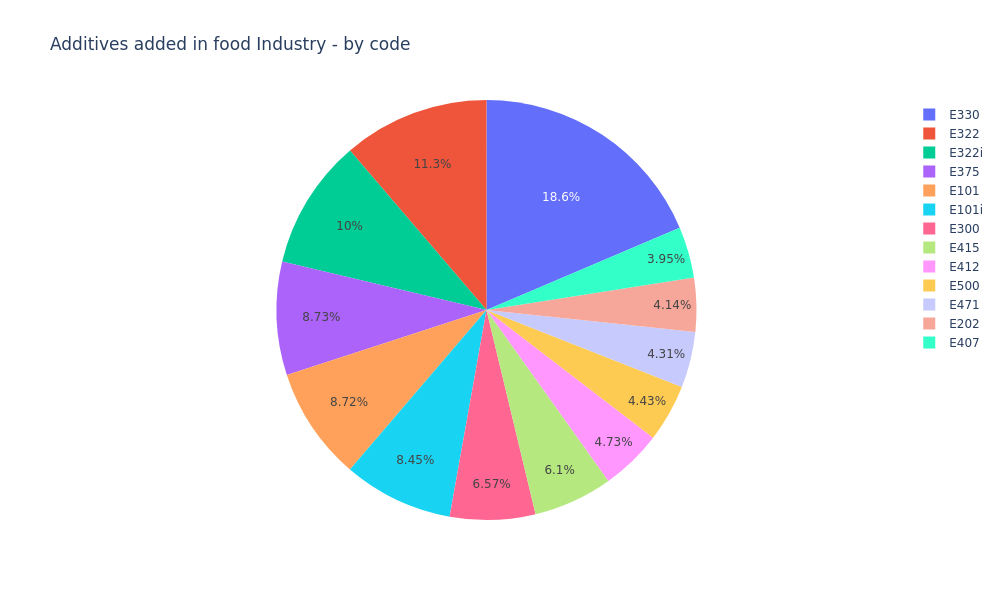

In [16]:
# plot the count of additives by code
additive_count_code = code_names.groupBy('code').count().withColumnRenamed('count', 'Total Count').orderBy(col('Total Count').desc())\
                            .filter(col('Total Count') > 10000)

additive_count_code_df = pd.DataFrame(additive_count_code.collect(), 
                                      columns=additive_count_code.columns)

# plot
fig = px.pie(additive_count_code_df,
             values='Total Count',
             names='code',
             title = "Additives added in food Industry - by code")

fig.update_layout(width=1000, height=600)

fig.write_image("plots/number_of_additives_by_code.png")
display(Image(filename='plots/number_of_additives_by_code.png'))

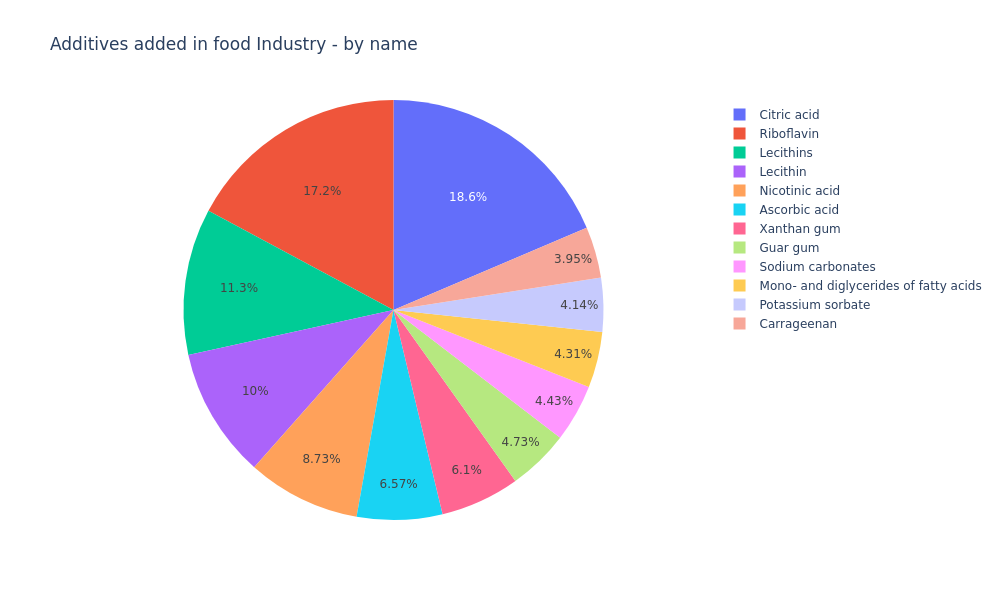

In [17]:
# plot the count of additives by name
additive_count_name = code_names.groupBy('name').count().withColumnRenamed('count', 'Total Count').orderBy(col('Total Count').desc())\
                            .filter(col('Total Count') > 10000)

additive_count_name_df = pd.DataFrame(additive_count_name.collect(), 
                                      columns=additive_count_name.columns)

# plot
fig = px.pie(additive_count_name_df,
             values='Total Count',
             names='name',
             title = "Additives added in food Industry - by name")

fig.update_layout(width=1000, height=600)

fig.write_image("plots/number_of_additives_by_name.png")
display(Image(filename='plots/number_of_additives_by_name.png'))

In [18]:
# get total additives and product count per brand
aggregated_additives_product_per_brand = additives_data.groupBy('brands').agg(
    sum('additives_n').alias('total_additives'),
    count('product_name').alias('product_count')
)

# Filter brands with fewer products but more additives
filtered_aggregated_additives_product_per_brand = aggregated_additives_product_per_brand.\
                                                  filter((col('product_count') < 700) & \
                                                  (col('total_additives') > 1000))

# look at the result
filtered_aggregated_additives_product_per_brand.show(truncate=False)

+------------------------------------+---------------+-------------+
|brands                              |total_additives|product_count|
+------------------------------------+---------------+-------------+
|Schnucks                            |1506           |438          |
|Ferrara Candy Company               |1262           |210          |
|Food Lion,  Food Town Stores Inc.   |1188           |392          |
|Nestlé                              |1482           |416          |
|Meijer,  Meijer  Inc.               |1196           |355          |
|Giant                               |1165           |362          |
|Shoprite                            |1840           |613          |
|Food Club                           |2489           |590          |
|Essential Everyday                  |1827           |504          |
|Hannaford,  Hannaford Bros. Co.     |1117           |392          |
|Food Lion                           |1975           |525          |
|Haribo                           

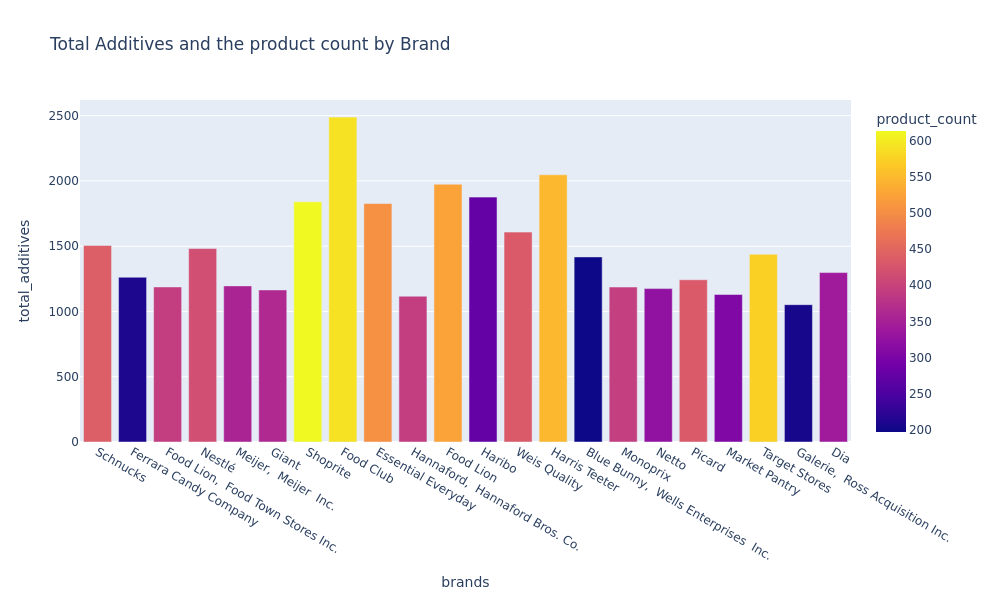

In [19]:
# plot the above data for clarity
# to pandas
filtered_aggregated_additives_product_per_brand_df = pd.DataFrame(filtered_aggregated_additives_product_per_brand.collect(),
                                                                  columns=filtered_aggregated_additives_product_per_brand.columns)

# plot
fig = px.bar(filtered_aggregated_additives_product_per_brand_df, 
             x='brands', 
             y='total_additives', 
             color='product_count', 
             barmode='group',  # Group bars for each brand
             title="Total Additives and the product count by Brand")

fig.update_layout(width=1000, height=600)

# plot the graph
fig.write_image("plots/total_additives_and_product_count_by_brand.png")
display(Image(filename='plots/total_additives_and_product_count_by_brand.png'))

#### United states data - Nutrition

In [20]:
# selecting only US data and nutrition, also normalizing the data
US_data = food_data.select('countries', 
                                'brands', 
                                'fiber_100g', 
                                'proteins_100g', 
                                'fat_100g', 
                                'sugars_100g', ).filter(food_data['countries']. \
                                rlike(r'(?i)\b(US|USA|en:us|United States of America|united states|united states of america|america)\b'))\
                                .withColumn('countries', lit('US')).\
                                dropna()

US_data.show()

+---------+--------------------+----------+-------------+--------+-----------+
|countries|              brands|fiber_100g|proteins_100g|fat_100g|sugars_100g|
+---------+--------------------+----------+-------------+--------+-----------+
|       US|      Torn & Glasser|       7.1|        17.86|   17.86|      17.86|
|       US|           Grizzlies|       7.1|        17.86|   57.14|       3.57|
|       US|                Unfi|       7.7|        13.46|   18.27|      11.54|
|       US|      Daddy's Muesli|       9.4|        14.06|   18.75|      15.62|
|       US|      Equal Exchange|       7.5|          5.0|    37.5|       42.5|
|       US|            Sunridge|       6.7|        16.67|   36.67|       3.33|
|       US|           Grizzlies|       9.1|        14.55|   18.18|      21.82|
|       US|           Grizzlies|      10.7|        14.29|   60.71|       3.57|
|       US|                Unfi|       3.3|         3.33|   26.67|      16.67|
|       US|                Unfi|       2.2|         

In [21]:
# brands count that are operating in United States
US_data.select('brands').distinct().show(truncate=False)

+---------------------------------------------+
|brands                                       |
+---------------------------------------------+
|Ling Ling                                    |
|Flower                                       |
|Jelly Belly                                  |
|Emerald Cove                                 |
|Dierbergs Kitchen                            |
|Mission Brand                                |
|Silk                                         |
|Bobbi's Best  Inc.                           |
|Emer'Ald                                     |
|Unilever Home And Personal Care Usa          |
|Whole Foods Market,  Allegro Coffee Company  |
|Joey D's                                     |
|Motto's                                      |
|Foco                                         |
|Kowalski's Markets,  Bergin Nut Company  Inc.|
|Koon Chun Hing Kee Soy & Sauce               |
|Lehi Roller Mills Co. Inc.                   |
|Napoleon                               

In [22]:
# total proteins and fibers by the brands in the United States
proteins_fibers_data = US_data.groupBy('brands').\
                        agg(round(sum('proteins_100g'), 2).alias('total proteins'),
                            round(sum('fiber_100g'), 2).alias('total fibers')).\
                        orderBy(col('total proteins').desc(),
                                col('total fibers').desc()).\
                        withColumnRenamed('brands', 'brand')

proteins_fibers_data.show()

+--------------------+--------------+------------+
|               brand|total proteins|total fibers|
+--------------------+--------------+------------+
|              Meijer|      12740.41|     4381.87|
|              Kroger|       11136.9|     3059.79|
|         Great Value|       8872.02|      2371.0|
|               Ahold|       8399.32|      2698.4|
|             Spartan|       8063.56|      2616.7|
|            Roundy's|        7806.1|      3167.6|
|                Weis|       7488.82|      1932.8|
|            Shoprite|       6676.54|      2003.7|
|       Target Stores|       6596.52|      2617.9|
|           Food Club|       4548.12|      1939.9|
|       Harris Teeter|       4427.51|      1900.1|
|        Weis Quality|       4226.04|      1452.7|
|Hannaford,  Hanna...|       4194.63|      1226.3|
|  Essential Everyday|       4149.15|     1836.41|
|              Hy-Vee|       4122.01|      1384.3|
|       Crystal Farms|       3967.74|         7.1|
|               Giant|       39

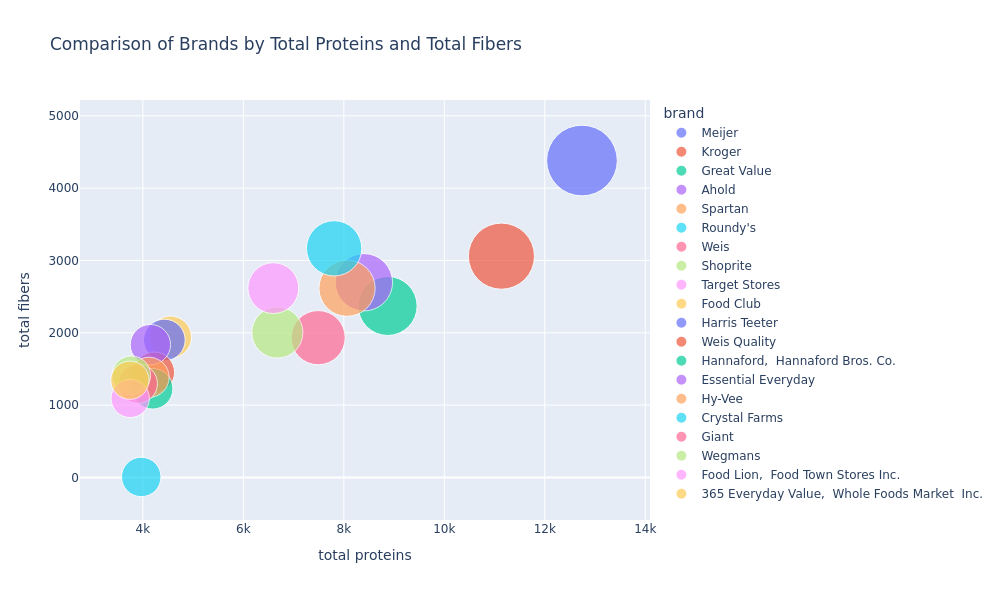

In [23]:
# plot the data for clarity
# pandas df
proteins_fibers_data_df = pd.DataFrame(data = proteins_fibers_data.collect(),
                                columns = proteins_fibers_data.columns)

# plot
fig = px.scatter(proteins_fibers_data_df[:20], 
                 x='total proteins', 
                 y='total fibers',
                 size = 'total proteins' ,
                 color='brand', 
                 size_max=50,
                 title = "Comparison of Brands by Total Proteins and Total Fibers"
)

fig.update_layout(width=1000, height=600)

fig.write_image("plots/comparison_of_brands_by_total_proteins_and_total_fibers.png")
display(Image(filename='plots/comparison_of_brands_by_total_proteins_and_total_fibers.png'))

In [24]:
# total sugars and fats by the brands in the United States
sugars_fat_data = US_data.groupBy('brands').\
                        agg(round(sum('sugars_100g'), 2).alias('total sugars'),
                            round(sum('fat_100g'), 2).alias('total fats')).\
                        orderBy(col('total sugars').desc(),
                                col('total fats').desc()).\
                        withColumnRenamed('brands', 'brand')

sugars_fat_data.show()

+--------------------+------------+----------+
|               brand|total sugars|total fats|
+--------------------+------------+----------+
|              Meijer|    20913.85|  18214.25|
|               Ahold|    15326.25|   13353.0|
|              Kroger|    15293.27|  15693.52|
|             Spartan|     15081.1|  11771.18|
|         Great Value|    13968.78|   12280.2|
|            Roundy's|    12697.79|   12103.0|
|       Target Stores|    12375.14|  10689.39|
|                Weis|    11941.73|   10458.1|
|           Food Club|     8440.11|   7777.88|
|Russell Stover,  ...|     8086.85|   3756.46|
|Wegmans,  Wegmans...|     8014.51|   4858.96|
|            Shoprite|     8008.35|   8676.98|
|Tops,  Tops Marke...|     7186.33|   3776.43|
|        Trader Joe's|     7179.87|   5103.35|
|     Momentum Brands|     6441.45|   1458.44|
|             Wegmans|     6303.74|   5542.86|
|Ghirardelli Choco...|     6295.94|   3852.49|
|            Schnucks|     6253.64|   5003.62|
|Meijer,  Mei

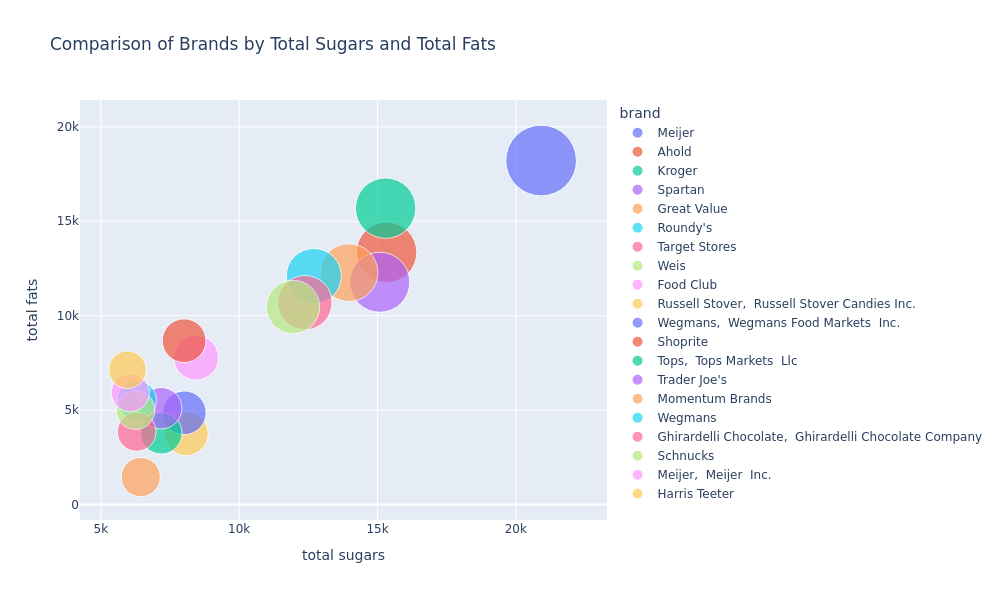

In [25]:
# plotting the data for clarity
# pandas df
sugars_fat_data_df = pd.DataFrame(data = sugars_fat_data.collect(),
                                  columns = sugars_fat_data.columns)

# plot
fig = px.scatter(sugars_fat_data_df[:20], 
                 x='total sugars', 
                 y='total fats',
                 size = 'total sugars' ,
                 color='brand', 
                 size_max=50,
                 title = "Comparison of Brands by Total Sugars and Total Fats"
)

fig.update_layout(width=1000, height=600)

fig.write_image("plots/comparison_of_brands_by_total_sugars_and_total_fats.png")
display(Image(filename='plots/comparison_of_brands_by_total_sugars_and_total_fats.png'))

#### Ingridients Analysis Used by the Food Industry

In [26]:
# select the ingredients data from the original data
ingredients_data = food_data.select(col('brands').alias('Brand'),
                                    col('ingredients_text').alias('Ingredients')).\
                            dropna()

ingredients_data.show(truncate=False)

+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Brand               |Ingredients                                                                                                                                                                                                                                                                                                                               

In [27]:
# cleaning and normalizing the data
ingredient_split = ingredients_data.withColumn("Ingredients_Array", split(col("Ingredients"), ", "))

ingredient_exploded = ingredient_split.withColumn("Ingredient", explode(ingredient_split["Ingredients_Array"]))

ingredients_data = ingredient_exploded.select('Brand', lower(col("Ingredient")).alias('Ingredient'))

# look at the dat
ingredients_data.show()

+--------------+--------------------+
|         Brand|          Ingredient|
+--------------+--------------------+
|Torn & Glasser|             peanuts|
|Torn & Glasser|         wheat flour|
|Torn & Glasser|               sugar|
|Torn & Glasser|          rice flour|
|Torn & Glasser|      tapioca starch|
|Torn & Glasser|                salt|
|Torn & Glasser|leavening (ammoni...|
|Torn & Glasser|        baking soda)|
|Torn & Glasser|    soy sauce (water|
|Torn & Glasser|            soybeans|
|Torn & Glasser|               wheat|
|Torn & Glasser|               salt)|
|Torn & Glasser|      potato starch.|
|     Grizzlies|   organic hazelnuts|
|     Grizzlies|     organic cashews|
|     Grizzlies|organic walnuts a...|
|     Grizzlies|organic sunflower...|
|     Grizzlies|           sea salt.|
|Bob's Red Mill|     organic polenta|
|          Unfi|         rolled oats|
+--------------+--------------------+
only showing top 20 rows



In [28]:
# top ingridients uses by all the brands
top_ingredients = ingredients_data.groupBy("Ingredient") \
                             .agg(count("Ingredient").alias("Ingredients_Count")) \
                             .orderBy(col("Ingredients_Count").desc())

top_ingredients.show()

# pandas df
top_ingredients_df = pd.DataFrame(top_ingredients.collect(), 
                                  columns = top_ingredients.columns)

+--------------------+-----------------+
|          Ingredient|Ingredients_Count|
+--------------------+-----------------+
|                salt|            83960|
|               sugar|            63856|
|               water|            58516|
|                 sel|            40121|
|               sucre|            30129|
|                 eau|            28116|
|         citric acid|            24609|
|              niacin|            19159|
|            dextrose|            18947|
|          corn syrup|            18337|
|          riboflavin|            17069|
|         folic acid)|            13808|
|        reduced iron|            13111|
|      natural flavor|            12417|
|              spices|            11806|
|thiamine mononitrate|            10998|
|            sea salt|            10977|
|high fructose cor...|            10795|
|         soybean oil|            10254|
|        soy lecithin|             9027|
+--------------------+-----------------+
only showing top

In [29]:
# clean the ingredients
def clean_ingredients(ingredient_str):
    # remove unwanted char
    cleaned_str = re.sub(r'[\[\]()\d]', '', ingredient_str)
    # remove multiple spaces
    cleaned_str = re.sub(r'\s+', ' ', cleaned_str).strip()
    return cleaned_str

top_ingredients_df['Ingredient'] = top_ingredients_df['Ingredient'].apply(clean_ingredients)

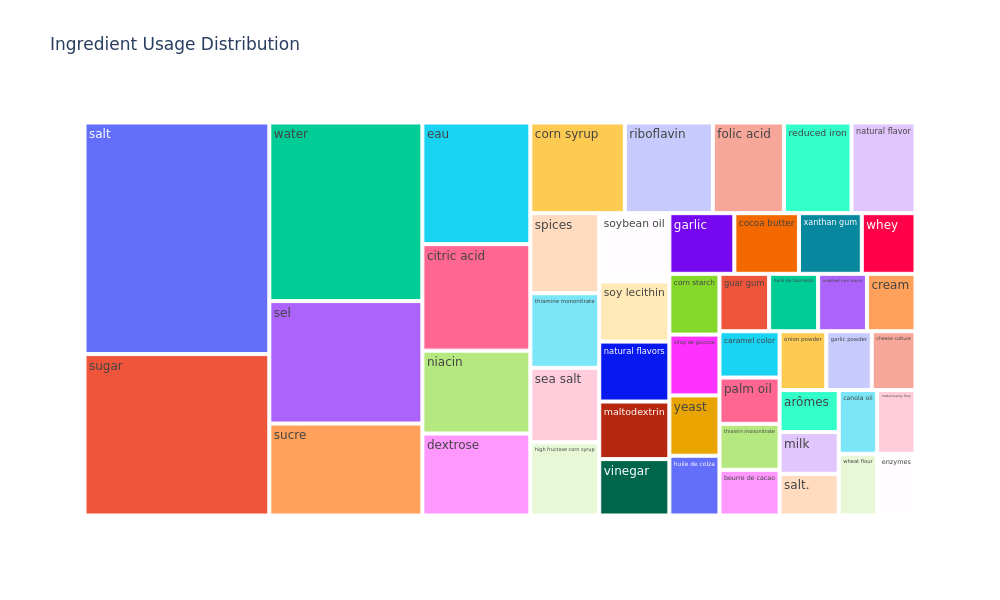

In [30]:
# plotting the above data
fig = px.treemap(top_ingredients_df[:50], 
                 path=['Ingredient'], 
                 values='Ingredients_Count', 
                 title="Ingredient Usage Distribution"
                )
fig.update_layout(width=1000, height=600)

fig.write_image("plots/ingredient_usage_distribution.png")
display(Image(filename='plots/ingredient_usage_distribution.png'))